<a href="https://colab.research.google.com/github/koulvivek/AIML/blob/master/Twitter_US_Airline_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description:Twitter US Airline SentimentData Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [5]:
# Import Libraries 

# For notebook plotting
%matplotlib inline

# Standard packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import pickle
# import sqlite3

# nltk for preprocessing of text data
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# sklearn for preprocessing and machine learning models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
# XGBoost for Machine Learning (Gradient Boosting Machine (GBM))
import xgboost as xgb

# Keras for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score,classification_report, recall_score, precision_score
from sklearn.metrics import confusion_matrix,mean_absolute_error,mean_squared_error, f1_score
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.chdir('/content/drive/My Drive/Colab Notebooks/NLP')

In [7]:
ls -l

total 3441
-rw------- 1 root root 3421431 Dec  5 18:24  Tweets.csv
-rw------- 1 root root  101261 Dec 11 21:11 'Twitter US Airline Sentiment.ipynb'


In [8]:

# Read the dataset

df= pd.read_csv('Tweets.csv')
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
# see  column or attribute names in df 
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

Data Preprocessing
The first step should be to check the shape of the dataframe and then check the number of null values in each column.

In this way we can get an idea of the redundant columns in the data frame depending on which columns have the highest number of null values.

In [10]:
print("Shape of the dataframe is",df.shape)
print("The number of nulls in each column are \n", df.isna().sum())

Shape of the dataframe is (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [11]:
# calculate the percentage of nulls or NA values in each column

print("Percentage  of null or na values in the dataframe(df)")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage  of null or na values in the dataframe(df)


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

tweet_coord , airline_sentiment_gold, negativereason_gold have more than 90% missing data. It will be better to delete these columns as they will not provide any constructive information.

In [12]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [13]:
# Select features or only required colums as per assignment

df_feature = df[['text', 'airline_sentiment']]
print('Feature selected DataFrame:')
df_feature.head(5)

Feature selected DataFrame:


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [14]:
df_feature['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

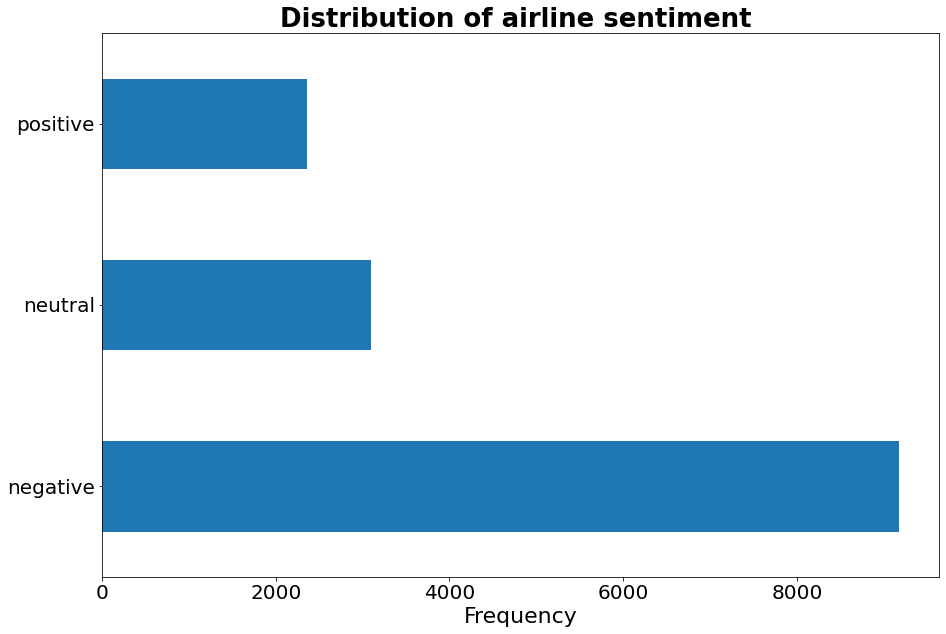

In [15]:
# Plot sentiment distribution
df['airline_sentiment'].value_counts().plot(kind = 'barh',
                                            figsize = (15,10));
plt.title('Distribution of airline sentiment ', 
          fontsize = 26, weight = 'bold')
plt.xlabel('Frequency', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

 About ~60 percent sentiment is negative..

Pre processing

I was trying to look for refrences to create a common component for Pre-processing..
Created a preprocessor class to perform all steps that need to be performed before the text data can be vectorized.This class will do the below:
Tokenization 
Removing stop words 
HTML Tag removal 
Lower case conversion
Stemming 
Transform the tokens back to one string

In [16]:
class PreProcessor:
    '''
    Easily performs all the standard preprocessing steps
    like removing stopwords, stemming, etc.
    Only input that you need to provide is the dataframe and column name for the tweets
    '''
    def __init__(self, df_feature, column_name):
        self.data = df_feature
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []
        
    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence
            
    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https': 
                filtered_sentence.append(w)
        return filtered_sentence
    
    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get truncated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]
    
    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)
    
    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)
            
        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.preprocessed

In [17]:
# Preprocess text and put it in a new column
preprocessor = PreProcessor(df_feature, 'text')
df_feature['cleaned_text'] = preprocessor.full_preprocess()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
del df_feature['text']    # deleted text column

In [19]:
# after cleaning in the dataframe df_feature
df_feature

,airline_sentiment,cleaned_text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus ve ad commerci experi ... t...
2,neutral,virginamerica n't today ... must mean need tak...
3,negative,virginamerica 's realli aggress blast obnoxi `...
4,negative,virginamerica 's realli big bad thing
...,...,...
14635,positive,americanair thank got differ flight chicago
14636,negative,americanair leav 20 minut late flight no warn ...
14637,neutral,americanair pleas bring american airlin blackb...
14638,negative,americanair money chang flight n't answer phon...


Split data into train, validation and test sets

In [20]:
df_feature.head()

,airline_sentiment,cleaned_text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus ve ad commerci experi ... t...
2,neutral,virginamerica n't today ... must mean need tak...
3,negative,virginamerica 's realli aggress blast obnoxi `...
4,negative,virginamerica 's realli big bad thing


In [21]:
X = df_feature["cleaned_text"]
y = df_feature["airline_sentiment"]

In [22]:
# Shape of data 
print(X.shape)
print(y.shape)

(14640,)
(14640,)


In [23]:
# Split 80:20
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## Data vectorization
Many machine learning models can only be trained on numerical input in the form of vectors or matrices. To prepare our tweets for the machine learning models we create  (tf-idf) vectorization and CountVectorization. The result of this vectorization is a sparse matrix.

## using TfidfVectorizer first 

In [24]:
# Create  matrix based on word frequency in tweets

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [25]:
# Print the size of our data

print(f'Train size: {X_train.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')

Train size: 11712 tweets
Test size: 2928 tweets
Amount of words (columns): 10097 words


Machine learning models using SVM, Bagging, Boostng, RandomForest

In [26]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from datetime import datetime

sv = SVC()
rf = RandomForestClassifier()

param_grid_rf = {"n_estimators": [10,20,30],
                 "max_depth": [2,3,5],
                 "min_samples_leaf": [2, 4]}

param_grid_sv = {'kernel': ['rbf','linear'], 
                  'gamma': [1e-3, 1e-4],
                  'C'    : [1, 10, 100]}

classifiers = [['Random_Forest_Tuned : ',GridSearchCV(rf,param_grid=param_grid_rf,cv=5,scoring='accuracy')],
               ['Xg_boost : ',XGBClassifier()],
               ['Bagging Classifier : ',BaggingClassifier()],
               ['Support Vector Machines_Tuned : ',GridSearchCV(sv,param_grid=param_grid_sv,cv=5,scoring='accuracy')]]

# class_predictions = []
for name,model in classifiers:
    model=model
    start_time = datetime.now()
    model.fit(X_train,y_train)
    predictions = model.predict(X_train)
    predictions1 = model.predict(X_test)
#   class_predictions.append(accuracy_score(y_test,predictions))
    print(f'{name}_Train_Accuracy :',accuracy_score(y_train,predictions))
    print(f'{name}_Test_Accuracy :',accuracy_score(y_test,predictions1))
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    print('--------------------------------------------------')

Random_Forest_Tuned : _Train_Accuracy : 0.6223531420765027
Random_Forest_Tuned : _Test_Accuracy : 0.6451502732240437
Duration: 0:00:09.834065
--------------------------------------------------
Xg_boost : _Train_Accuracy : 0.7403517759562842
Xg_boost : _Test_Accuracy : 0.7438524590163934
Duration: 0:00:07.947202
--------------------------------------------------
Bagging Classifier : _Train_Accuracy : 0.9715676229508197
Bagging Classifier : _Test_Accuracy : 0.7363387978142076
Duration: 0:00:15.447428
--------------------------------------------------
Support Vector Machines_Tuned : _Train_Accuracy : 0.8971140710382514
Support Vector Machines_Tuned : _Test_Accuracy : 0.7971311475409836
Duration: 0:11:48.498393
--------------------------------------------------


In [27]:
#onehot encoding  You need to convert to numpy array ..
y_train = pd.get_dummies(y_train).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

## Nueral network using Keras

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(64,activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                646272    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 650,627
Trainable params: 650,627
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_train,y_train,epochs=30,batch_size=128,validation_data=(X_test, y_test))

Epoch 1/30
92/92 [==============================] - 0s 5ms/step - loss: 0.5623 - accuracy: 0.6176 - val_loss: 0.5269 - val_accuracy: 0.6452
Epoch 2/30
92/92 [==============================] - 0s 4ms/step - loss: 0.5423 - accuracy: 0.6224 - val_loss: 0.5255 - val_accuracy: 0.6452
Epoch 3/30
92/92 [==============================] - 0s 4ms/step - loss: 0.5389 - accuracy: 0.6224 - val_loss: 0.5217 - val_accuracy: 0.6452
Epoch 4/30
92/92 [==============================] - 0s 3ms/step - loss: 0.5359 - accuracy: 0.6224 - val_loss: 0.5172 - val_accuracy: 0.6452
Epoch 5/30
92/92 [==============================] - 0s 4ms/step - loss: 0.5308 - accuracy: 0.6224 - val_loss: 0.5110 - val_accuracy: 0.6452
Epoch 6/30
92/92 [==============================] - 0s 3ms/step - loss: 0.5241 - accuracy: 0.6224 - val_loss: 0.5029 - val_accuracy: 0.6452
Epoch 7/30
92/92 [==============================] - 0s 3ms/step - loss: 0.5163 - accuracy: 0.6224 - val_loss: 0.4926 - val_accuracy: 0.6452
Epoch 8/30
92/92 [==

<function matplotlib.pyplot.show>

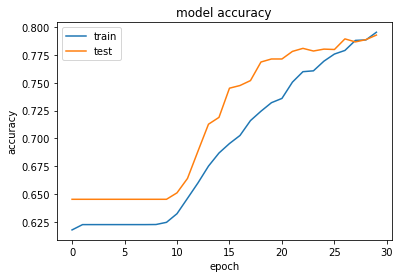

In [31]:

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc = "upper left")
plt.show

Sequential Model for Nueral network is almost similarly accurate as SVM when using TfidfVectorizer

## Lets try to use CountVectorizer now 

In [32]:
X_cv = df_feature["cleaned_text"]
y_cv = df_feature["airline_sentiment"]

print(X_cv.shape)
print(y_cv.shape)



(14640,)
(14640,)


In [33]:
# Split 80:20
X_train,X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.2,random_state=42)

In [34]:
# Create  matrix based on word frequency in tweets

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [35]:
# Print the size of our data

print(f'Train size: {X_train.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')

Train size: 11712 tweets
Test size: 2928 tweets
Amount of words (columns): 10097 words


Machine learning models ..

In [36]:
sv = SVC()
rf = RandomForestClassifier()

param_grid_rf = {"n_estimators": [10,20,30],
                 "max_depth": [2,3,5],
                 "min_samples_leaf": [2, 4]}

param_grid_sv = {'kernel': ['rbf','linear'], 
                  'gamma': [1e-3, 1e-4],
                  'C'    : [1, 10, 100]}

classifiers = [['Random_Forest_Tuned : ',GridSearchCV(rf,param_grid=param_grid_rf,cv=5,scoring='accuracy')],
               ['Xg_boost : ',XGBClassifier()],
               ['Bagging Classifier : ',BaggingClassifier()],
               ['Support Vector Machines_Tuned : ',GridSearchCV(sv,param_grid=param_grid_sv,cv=5,scoring='accuracy')]]

# class_predictions = []
for name,model in classifiers:
    model=model
    start_time = datetime.now()
    model.fit(X_train,y_train)
    predictions = model.predict(X_train)
    predictions1 = model.predict(X_test)
#   class_predictions.append(accuracy_score(y_test,predictions))
    print(f'{name}_Train_Accuracy :',accuracy_score(y_train,predictions))
    print(f'{name}_Test_Accuracy :',accuracy_score(y_test,predictions1))
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    print('--------------------------------------------------')

Random_Forest_Tuned : _Train_Accuracy : 0.6223531420765027
Random_Forest_Tuned : _Test_Accuracy : 0.6451502732240437
Duration: 0:00:09.414796
--------------------------------------------------
Xg_boost : _Train_Accuracy : 0.7253244535519126
Xg_boost : _Test_Accuracy : 0.7370218579234973
Duration: 0:00:04.495250
--------------------------------------------------
Bagging Classifier : _Train_Accuracy : 0.9736168032786885
Bagging Classifier : _Test_Accuracy : 0.7503415300546448
Duration: 0:00:12.179922
--------------------------------------------------
Support Vector Machines_Tuned : _Train_Accuracy : 0.8911372950819673
Support Vector Machines_Tuned : _Test_Accuracy : 0.7995218579234973
Duration: 0:15:10.839023
--------------------------------------------------


In [37]:
#onehot encoding  You need to convert to numpy array ..
y_train = pd.get_dummies(y_train).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

Nueral network using Keras...

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(64,activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                646272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 650,627
Trainable params: 650,627
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_cv = model.fit(X_train,y_train,epochs=30,batch_size=128,validation_data=(X_test, y_test))

Epoch 1/30
92/92 [==============================] - 0s 5ms/step - loss: 0.5572 - accuracy: 0.6033 - val_loss: 0.5083 - val_accuracy: 0.6452
Epoch 2/30
92/92 [==============================] - 0s 3ms/step - loss: 0.5138 - accuracy: 0.6224 - val_loss: 0.4766 - val_accuracy: 0.6452
Epoch 3/30
92/92 [==============================] - 0s 4ms/step - loss: 0.4851 - accuracy: 0.6224 - val_loss: 0.4443 - val_accuracy: 0.6452
Epoch 4/30
92/92 [==============================] - 0s 4ms/step - loss: 0.4585 - accuracy: 0.6251 - val_loss: 0.4184 - val_accuracy: 0.6469
Epoch 5/30
92/92 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy: 0.6549 - val_loss: 0.3962 - val_accuracy: 0.7210
Epoch 6/30
92/92 [==============================] - 0s 3ms/step - loss: 0.4166 - accuracy: 0.6964 - val_loss: 0.3807 - val_accuracy: 0.7462
Epoch 7/30
92/92 [==============================] - 0s 4ms/step - loss: 0.4020 - accuracy: 0.7214 - val_loss: 0.3659 - val_accuracy: 0.7568
Epoch 8/30
92/92 [==

<function matplotlib.pyplot.show>

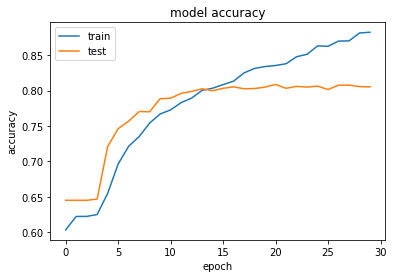

In [43]:
plt.plot(history_cv.history["accuracy"])
plt.plot(history_cv.history_cv["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc = "upper left")
plt.show

# Summary



1.   SVM has almost same test accuracy for CountVectorizer and TfidfVectorizer.
2.   CountVectorizer using Sequential Nueral network has better Accuracy for the same model using TfidfVectorizer.


About ~60 percent sentiment is negative.


